In [1]:
# Install Pytorch & other libraries
%pip install "torch>=2.4.0" tensorboard torchvision
%pip install -U transformers

# Install Hugging Face libraries
%pip install  --upgrade \
  "datasets==3.3.2" \
  "accelerate==1.4.0" \
  "evaluate==0.4.3" \
  "bitsandbytes==0.45.3" \
  "trl==0.15.2" \
  "peft==0.14.0" \
  "pillow==11.1.0" \
  protobuf \
  sentencepiece

%pip install wandb==0.19.7

  Using cached protobuf-4.23.4-cp37-abi3-manylinux2014_x86_64.whl.metadata (540 bytes)
Using cached protobuf-4.23.4-cp37-abi3-manylinux2014_x86_64.whl (304 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached protobuf-6.30.2-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
Using cached protobuf-6.30.2-cp39-abi3-manylinux2014_x86_64.whl (316 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.1

In [2]:
import huggingface_hub
huggingface_hub.login()

Token has not been saved to git credential helper.


In [3]:
from datasets import load_dataset
from PIL import Image

instruction = 'Convert the equation images to LaTeX equations.'
def convert_to_conversation(sample):
    conversation = [
        { 'role': 'user',
          'content' : [
            {'type' : 'text',  'text'  : instruction},
            {'type' : 'image', 'image' : sample['image']} ]
        },
        { 'role' : 'assistant',
          'content' : [
            {'type' : 'text',  'text'  : sample['text']} ]
        },
    ]
    return { 'messages' : conversation }


def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    image_inputs = []
    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))
    return image_inputs

# Load dataset from the hub
#dataset = load_dataset("unsloth/LaTeX_OCR", split="train")
dataset_train = load_dataset('unsloth/LaTeX_OCR', split='train[:3000]')

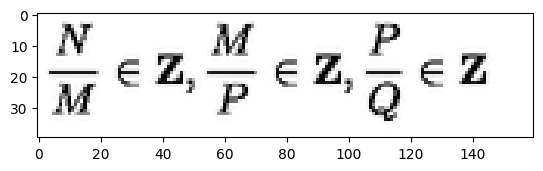

In [4]:
import matplotlib.pyplot as plt
train_image = dataset_train[0]['image']
plt.imshow(train_image)

In [5]:
print(dataset_train[0]['text'])

{ \frac { N } { M } } \in { \bf Z } , { \frac { M } { P } } \in { \bf Z } , { \frac { P } { Q } } \in { \bf Z }


In [6]:
from tqdm import tqdm
converted_dataset_train = [
    convert_to_conversation(sample) \
    for sample in tqdm(dataset_train, total=len(dataset_train))
]

100%|██████████| 3000/3000 [00:01<00:00, 2425.53it/s]


In [7]:
print(converted_dataset_train[0])

{'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'Convert the equation images to LaTeX equations.'}, {'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40 at 0x78F7172CB6A0>}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}


In [8]:
%pip install flash-attn --no-build-isolation

Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

# Hugging Face model id
model_id = "google/gemma-3-4b-pt" # or `google/gemma-3-12b-pt`, `google/gemma-3-27-pt`

# Define model init arguments
model_kwargs = dict(
    attn_implementation="flash_attention_2", 
    torch_dtype=torch.bfloat16,
    device_map="auto", # Let torch decide how to load the model
)

# BitsAndBytesConfig int-4 config
model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

# Load model and tokenizer
model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained("google/gemma-3-4b-it")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [10]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=8,
    bias="none",
    target_modules=[
 'down_proj',
 'o_proj',
 'k_proj',
 'q_proj',
 'gate_proj',
 'up_proj',
 'v_proj'],
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [11]:
from trl import SFTConfig

args=SFTConfig(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        num_train_epochs=1, # For full training runs over the dataset.
        learning_rate=2e-4,
        bf16=True,
        logging_steps=200,
        save_strategy='steps',
        save_steps=200,
        save_total_limit=2,
        optim='adamw_8bit',
        weight_decay=0.01,
        lr_scheduler_type='linear',
        seed=3407,
        output_dir='outputs',
        report_to='none',     
        remove_unused_columns=False,
        dataset_text_field='',
        dataset_kwargs={'skip_prepare_dataset': True},
        max_seq_length=1024,
)

# Create a data collator to encode text and image pairs
def collate_fn(examples):
    texts = []
    images = []
    for example in examples:
        image_inputs = process_vision_info(example["messages"])
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        texts.append(text.strip())
        images.append(image_inputs)

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens and image tokens in the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

In [12]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=converted_dataset_train,
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [13]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.
It is strongly recommended to train Gemma3 models with the `eager` attention implementation instead of `flash_attention_2`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step,Training Loss
200,1.379300
400,0.465800
600,0.383500


In [14]:
# free the memory again
del model
del trainer
torch.cuda.empty_cache()

In [15]:
import torch

# Load Model with PEFT adapter
model = AutoModelForImageTextToText.from_pretrained(
  args.output_dir,
  device_map="auto",
  torch_dtype=torch.bfloat16,
  attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(args.output_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
import requests
from PIL import Image

image = Image.open("/teamspace/studios/this_studio/latex1.jpg").convert("RGB")
instruction = 'Convert the equation images to LaTeX equations.'


def generate_equation(model, processor):
    # Convert sample into messages and then apply the chat template
    messages = [
        { 'role': 'user',
          'content' : [
            {'type' : 'text',  'text'  : instruction},
            {'type' : 'image', 'image' : image} ]
        },
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages)
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)
    
    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# generate the description
description = generate_equation(model, processor)
print(description)

H ^ { \prime } = \beta N \int d \lambda \biggl \{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \biggr \} .


In [17]:
import requests
from PIL import Image

image = Image.open("/teamspace/studios/this_studio/latex6.jpg").convert("RGB")
instruction = 'Convert the equation images to LaTeX equations.'


def generate_equation(model, processor):
    # Convert sample into messages and then apply the chat template
    messages = [
        { 'role': 'user',
          'content' : [
            {'type' : 'text',  'text'  : instruction},
            {'type' : 'image', 'image' : image} ]
        },
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages)
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)
    
    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# generate the description
description = generate_equation(model, processor)
print(description)

E _ { 1 } ^ { - } ( j _ { 2 } ) = ( - 1 ) ^ { n } \prod _ { k = 1 } ^ { n } c _ { k } \mathcal { E } ^ { n } ( \bar { y } _ { 1 } , \dots , \bar { y } _ { n } ) + \mathrm { o t h e r t e r m s } .


In [18]:
import requests
from PIL import Image

image = Image.open("/teamspace/studios/this_studio/latex2.jpg").convert("RGB")
instruction = 'Convert the equation images to LaTeX equations.'


def generate_equation(model, processor):
    # Convert sample into messages and then apply the chat template
    messages = [
        { 'role': 'user',
          'content' : [
            {'type' : 'text',  'text'  : instruction},
            {'type' : 'image', 'image' : image} ]
        },
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages)
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)
    
    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# generate the description
description = generate_equation(model, processor)
print(description)

\left[ \left[ B _ { n } ^ { + } , b _ { 2 } ^ { - } \right] , b _ { 2 } ^ { + } \right] = n B _ { n } ^ { + } , \quad \left[ \left[ B _ { n } ^ { - } , b _ { 2 } ^ { + } \right] , b _ { 2 } ^ { - } \right] = n B _ { n } ^ { - } .


In [19]:
import requests
from PIL import Image

image = Image.open("/teamspace/studios/this_studio/latex3.jpg").convert("RGB")
instruction = 'Convert the equation images to LaTeX equations.'


def generate_equation(model, processor):
    # Convert sample into messages and then apply the chat template
    messages = [
        { 'role': 'user',
          'content' : [
            {'type' : 'text',  'text'  : instruction},
            {'type' : 'image', 'image' : image} ]
        },
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages)
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)
    
    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# generate the description
description = generate_equation(model, processor)
print(description)

+ \int d ^ { 3 } x J _ { \mu } ^ { \prime } ( x ) a _ { \mu } ( x ) + \int d ^ { 3 } x J _ { s } ^ { \prime } ( x ) \displaystyle \varphi ( x ) ,


In [20]:
import requests
from PIL import Image

image = Image.open("/teamspace/studios/this_studio/latex4.jpg").convert("RGB")
instruction = 'Convert the equation images to LaTeX equations.'


def generate_equation(model, processor):
    # Convert sample into messages and then apply the chat template
    messages = [
        { 'role': 'user',
          'content' : [
            {'type' : 'text',  'text'  : instruction},
            {'type' : 'image', 'image' : image} ]
        },
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages)
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)
    
    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# generate the description
description = generate_equation(model, processor)
print(description)

M = \frac { V _ { p } \Omega _ { d - 1 } } { 1 6 \pi G } \rho _ { 0 } ^ { d - 2 } \big [ d - 1 + ( d - 2 ) \sinh ^ { 2 } \alpha \big ] \ .


In [21]:
import requests
from PIL import Image

image = Image.open("/teamspace/studios/this_studio/latex5.jpg").convert("RGB")
instruction = 'Convert the equation images to LaTeX equations.'


def generate_equation(model, processor):
    # Convert sample into messages and then apply the chat template
    messages = [
        { 'role': 'user',
          'content' : [
            {'type' : 'text',  'text'  : instruction},
            {'type' : 'image', 'image' : image} ]
        },
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages)
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)
    
    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# generate the description
description = generate_equation(model, processor)
print(description)

\lambda _ { R } \equiv { \frac { 1 } { 3 ! } } \left| \frac { d ^ { 4 } \varphi ( \Phi ) } { d \Phi ^ { 4 } } \right| _ { \Phi = 0 } = \lambda { \frac { 1 - 6 \lambda I _ { ( 2 ) } [ m _ { R } ^ { 2 } ] } { 1 + 3 \lambda I _ { ( 2 ) } [ m _ { R } ^ { 2 } ] } } ,


In [22]:
import requests
from PIL import Image


image = Image.open("/teamspace/studios/this_studio/latex7_test.jpg").convert("RGB")
instruction = 'Convert the equation images to LaTeX equations.'


def generate_equation(model, processor):
    # Convert sample into messages and then apply the chat template
    messages = [
        { 'role': 'user',
          'content' : [
            {'type' : 'text',  'text'  : instruction},
            {'type' : 'image', 'image' : image} ]
        },
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages)
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)
    
    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# generate the description
description = generate_equation(model, processor)
print(description)

\frac { 1 } { ( \pi ) ^ { 4 } } \int \int d ^ { 4 } \vec { x } \phi ^ { n } ( \vec { x } ) \neq \frac { 1 } { ( \pi ) ^ { 4 } } \int d ^ { 4 } x \phi ^ { n } ( x ) \qquad n \geq 2
